In [1]:
import numpy as np
import pandas as pd
from skimage.data import imread
import matplotlib.pyplot as plt

In [2]:
import os
print(os.listdir("../input"))

['test.7z', 'test_v2', 'train.7z', 'train_v2', '.ipynb_checkpoints', 'audio', 'sample_submission.7z', 'train', 'test', 'train_ship_segmentations_v2.csv', 'sample_submission.csv', 'audio_test']


In [3]:
train_v2 = os.listdir('../input/train_v2')
print(len(train_v2))

test_v2 = os.listdir('../input/test_v2')
print(len(test_v2))

192559
15606


# Encoding f(x)

In [4]:
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [5]:
masks = pd.read_csv('../input/train_ship_segmentations_v2.csv')
masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
type(masks['EncodedPixels'][3])

str

In [7]:
train = masks
train.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


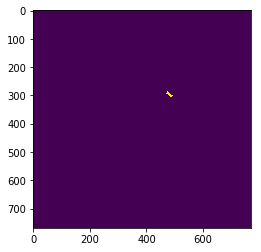

In [8]:
plt.imshow(rle_decode(masks['EncodedPixels'][3]))

In [9]:
rle_decode(masks['EncodedPixels'][3])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [10]:
train['exist_ship'] = train['EncodedPixels'].fillna(0)
train.loc[train['exist_ship']!=0, 'exist_ship']=1
del train['EncodedPixels']

In [11]:
train.head()

,ImageId,exist_ship
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,000194a2d.jpg,1


In [12]:
print(len(train['ImageId']))
print(train['ImageId'].value_counts().shape[0])
train_gp = train.groupby('ImageId').sum().reset_index()
train_gp.loc[train_gp['exist_ship']>0,'exist_ship']=1

231723
192556


In [13]:
len(train_gp)

192556

In [14]:
train_gp.head()

,ImageId,exist_ship
0,00003e153.jpg,0
1,0001124c7.jpg,0
2,000155de5.jpg,1
3,000194a2d.jpg,1
4,0001b1832.jpg,0


In [15]:
print(train_gp['exist_ship'].value_counts())
train_gp= train_gp.sort_values(by='exist_ship')
train_gp = train_gp.drop(train_gp.index[0:100000])

0    150000
1     42556
Name: exist_ship, dtype: int64


In [16]:
print(train_gp['exist_ship'].value_counts())

0    50000
1    42556
Name: exist_ship, dtype: int64


# Sample

In [17]:
train_sample = train_gp.sample(1000)
print(train_sample['exist_ship'].value_counts())
print (train_sample.shape)

0    543
1    457
Name: exist_ship, dtype: int64
(1000, 2)


In [18]:
train_sample.head()

,ImageId,exist_ship
9017,0bf357d36.jpg,0
103038,8901e59b4.jpg,1
138935,b89291513.jpg,1
76217,6550a67ee.jpg,0
72190,5ffd6c7d0.jpg,1


* Train_path = '../input/train_v2/'
* Test_path = '../input/test_v2/'

# Resize Image

In [19]:
from PIL import Image
data = np.empty((len(train_sample['ImageId']),256,256,3), dtype=np.float32)
data_target = np.empty((len(train_sample['ImageId'])), dtype=np.int32)

train_v2 = os.listdir('../input/train_v2')
print(len(train_v2))

test_v2 = os.listdir('../input/test_v2')
print(len(test_v2))

image_name_list = train_v2
index = 0
for image_name in image_name_list:
    if image_name in list(train_sample['ImageId']):
        imageA = Image.open('../input/train_v2/' + image_name).resize((256,256)).convert('RGB')
        data[index]=imageA
        data_target[index]=train_sample[train_gp['ImageId'].str.contains(image_name)]['exist_ship'].iloc[0]
        index+=1

192559
15606


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [20]:
print(data.shape)
print(data_target.shape)

(1000, 256, 256, 3)
(1000,)


In [21]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(data,data_target, test_size = 0.2)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((800, 256, 256, 3), (200, 256, 256, 3), (800,), (200,))

In [22]:
plt.imshow(rle_decode(masks['EncodedPixels'][3]))

KeyError: 'EncodedPixels'

In [ ]:
(rle_decode(masks['EncodedPixels'][24755])).shape

In [ ]:
y_train

In [ ]:
a=(masks['EncodedPixels'][np.where(train_sample['ImageId'] == 'a4329c9c1.jpg')[0][0]])

In [ ]:
math.isnan(a)

In [ ]:
image_name = "0374c49ba.jpg"

In [ ]:
rle_decode(masks['EncodedPixels'][np.where(train_sample['ImageId'] == image_name)[0][0]])

In [ ]:
math.isnan(sum(sum(rle_decode(masks['EncodedPixels'][np.where(train_sample['ImageId'] == image_name)[0][0]]))))

In [ ]:
train_sample[:5]

In [ ]:
np.zeros((768,768), dtype=np.float32)

# New Start

In [45]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(type(x_train[0][0][0][0]))
print(type(x_val[0][0][0][0]))
print(type(y_train[0]))
print(type(y_val[0]))

(800, 256, 256, 3)
(200, 256, 256, 3)
(800,)
(200,)
<class 'numpy.float32'>
<class 'numpy.float32'>
<class 'numpy.int32'>
<class 'numpy.int32'>


In [41]:
x_train[0].max()

154.0

In [48]:
y_train[:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

In [37]:
type(x_train)

numpy.ndarray

In [30]:
import tensorflow as tf
'''
x - according to the documentation I am passing a dictionary of my training features
y - passing the training labels
batch_size - how many images I want to pass to my NN in a single training step. 
             The gradients and the loss for the training step will be calculated only on these images. 
num_epochs - when I want to complete the execution of this method. With the current setting (1) 
             when the input function goes through all images once it will complete.
shuffle    - do I want to read the images in order or no. It is a better strategy to 
             shuffle within the training images during training.
'''
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={'x':x_train},
      y=y_train,
      batch_size=20,
      num_epochs=2,
      shuffle=True)

'''
What the eval_input_fn will do with its current settings is to read the entire training dataset 
(in order) using batch_size of 128 (default setting). 

Keep in mind that it will also terminate when completes 1 epoch.
'''
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':x_val},
    y=y_val,
    shuffle=False,
    num_epochs=2)

In [31]:
# test_data.shape

In [32]:
# test_data[400:].shape

In [33]:
def cnn_model_function(features, labels, mode):
    '''
    This is the function which describes the structure of the neural network
    '''
    
    # input layer
    # reshaping x to 4-D tensor: [batch_size, width, height, channels]
    # features['x'] - the dictionary we passed for x in the input functions
    layer_1 = tf.reshape(features['x'], [-1, 256, 256, 3])
    
    # convolution layer 1
    # computes 32 features using 10x10 filter with ReLU activation.
    # input tensor: [batch_size, 256, 256, 3]
    # output tensor: [batch_size, 256, 256, 32]
    layer_2 = tf.layers.conv2d(                          
                inputs=layer_1,
                filters=10,
                kernel_size=[10, 10],
                padding="same",
                activation=tf.nn.relu)
    
    # convolution layer 2
    # computes 32 features using 5x5 filter with ReLU activation.
    # input tensor: [batch_size, 256, 256, 32]
    # output tensor: [batch_size, 256, 256, 64]
    layer_3 = tf.layers.conv2d(
                inputs=layer_2,
                filters=20,
                kernel_size=[5, 5],
                padding="same",
                activation=tf.nn.relu)
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 256, 256, 64]
    # Output Tensor Shape: [batch_size, 256 * 256 * 64]
    layer_4 = tf.reshape(layer_3, [-1, 256 * 256 * 20])
    
    # Dense Layer
    # Densely connected layer with 1024 neurons
    # Input Tensor Shape: [batch_size, 256 * 256 * 64]
    # Output Tensor Shape: [batch_size, 1024]
    layer_5 = tf.layers.dense(inputs=layer_4, units=20, activation=tf.nn.relu)
    
    # Dropout operation; 0.6 probability that element will be kept
    # notice that this layer will perform droupout only during training!
    layer_6 = tf.layers.dropout(inputs=layer_5, rate=0.4, training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    # Logits layer
    # Input Tensor Shape: [batch_size, 1024]
    # Output Tensor Shape: [batch_size, 10]
    logits = tf.layers.dense(inputs=layer_6, units=2)
    
    # define the values which our neural network will output
    # classes - which number the NN 'thinks' is on the image
    # probabilities - how certain our NN is about its prediction
    predictions = {
                "classes": tf.argmax(input=logits, axis=1),
                "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    # here we define what happens if we call the predict method of our estimator
    # with the current settings it will return the dictionary defined above
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # here we define the loss for our training (the thing we minimize)
    # I do not need to perform one-hot-encoding to my training labels because the method
    # sparse_softmax_cross_entropy will do that for me and I don't need to think about that
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # here we define how we calculate our accuracy
    # if you want to monitor your training accuracy you need these two lines
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions['classes'], name='acc_op')
    tf.summary.scalar('accuracy', accuracy[1])
    
    # here we define what happens if we call the train method of our estimator
    # with its current settings it will adjust the weights and biases of our neurons
    # using the Adam Optimization Algorithm based on the loss function we defined earlier
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        tf.identity(accuracy[1], name='train_accuracy')
        tf.summary.scalar('train_accuracy', accuracy[1])
        eval_metric_ops = {'train_accuracy':accuracy}
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op, eval_metric_ops=eval_metric_ops)
    
    # what evaluation metric we want to show
    tf.identity(accuracy[1], name='val_accuracy')
    tf.summary.scalar('val_accuracy', accuracy[1])
    eval_metric_ops = {'val_accuracy':accuracy}
    # here we define what happens if we call the evaluate method of our estimator
    # with its current settings it will display the loss and the accuracy which we defined earlier
    return tf.estimator.EstimatorSpec(
                mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [34]:
tf.logging.set_verbosity(tf.logging.INFO)

In [35]:
# first we define a folder where tensorflow will keep its progress
# this includes periodical saves of our weight, biases, accuracy, loss and etc.
# so if we have more training images we can simply continue training on them
OUTDIR = './a_cnn_model'

# we create an estimator object which:
# - is using the Neural Net structure from the cnn_model_function
# - reads/writes the files written in the directory which we defined earlier
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_function, model_dir=OUTDIR)

# here we start the FileWriter method which will actually save the progress in the folder defined above
file_writer = tf.summary.FileWriter(OUTDIR)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './CNN_CLASSIFIER', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1a88921710>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [36]:
# a small helper function which trains/evaluates our network for a given number of epochs
# remember that our input functions go through the datasets only once
def train_and_evaluate(estimator, epochs=100):
    for i in range(epochs):
        estimator.train(input_fn=train_input_fn,steps=20)
        estimator.evaluate(input_fn=eval_input_fn)

# and here we finally start training/evaluating the NN for 30 epochs
train_and_evaluate(cnn_classifier)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./CNN_CLASSIFIER/model.ckpt-896
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 896 into ./CNN_CLASSIFIER/model.ckpt.
INFO:tensorflow:loss = 0.6751631, step = 897


KeyboardInterrupt: 

In [ ]:
test_v2 = os.listdir('../input/test_v2')
print(len(test_v2))
type(len(test_v2))

In [ ]:
test_v2

In [ ]:
"""
from PIL import Image
test_data = np.empty((len(test_v2),256,256,3), dtype=np.float32)
test_data_target = np.empty((len(test_v2)), dtype=np.int32)
image_name_list = test_v2
index = 0
for image_name in image_name_list:
    if image_name in list(test_v2):
        imageA = Image.open('../input/test_v2/' + image_name).resize((256,256)).convert('RGB')
        test_data[index]=imageA
        # prediction
        index+=1
"""

In [ ]:
'''
What the predict_input_fn will do with its current settings is to read the entire inference dataset 
(in order) using batch_size of 128 (default setting). 

Keep in mind that it will also terminate when completes 1 epoch.
'''
predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_data},
    shuffle=False,
    num_epochs=2)

In [ ]:
test_data.shape

In [ ]:
len(test_data)

In [ ]:
generator = cnn_classifier.predict(input_fn=predict_input_fn)

In [ ]:
# a=next(generator)

In [ ]:
# a['classes']

In [ ]:
"""
preds1 = []
b1 = []
for i in range(400):
    a = next(generator)
    preds.append(a['classes'])
    b.append(i)
"""

In [ ]:
def unique(list1): 
  
    # intilize a null list 
    unique_list = [] 
      
    # traverse for all elements 
    for x in list1: 
        # check if exists in unique_list or not 
        if x not in unique_list: 
            unique_list.append(x) 
    # print list 
    for x in unique_list: 
        print (x, end=" ")

In [ ]:
preds = []
b = []
for i in range(15606):
    a = next(generator)
    preds.append(a['classes'])
    b.append(i)

In [ ]:
unique(preds)

In [ ]:
len(preds)

In [ ]:
print(type(preds))
print(type(test_data))
print(len(preds))
#b[-1]

In [ ]:
c=preds[:5]
c

In [ ]:
e = [7691,748,8459,748,9227,748,9995,748,10763,748,1153]
f = (' '.join(map(str, e)))
print(f)
print(type(f))

In [ ]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
# empty image
zp_dim = 10
out_img = np.ones((768-2*zp_dim, 768-2*zp_dim), dtype=bool)
out_img = np.pad(out_img, ((zp_dim, zp_dim),), mode='constant', constant_values=0)
plt.matshow(out_img)
print(out_img.shape)
pos_ship_str = rle_encode(out_img)
print(pos_ship_str[:50])

In [ ]:
pos_ship_str

In [ ]:
#submission_df['EncodedPixels'] = submission_df['score'].map(lambda x: pos_ship_str if x>0.5 else None)

In [ ]:
p=preds[1]
p

In [ ]:
for i in range(len(preds)):
    if preds[i] == 0:
        preds[i] = None
    if preds[i] == '7691 748 8459 748 9227 748 9995 748 10763 748 1153':
        preds[i] = pos_ship_str

In [ ]:
preds[:10]

In [ ]:
d=test_v2[:5]
d

In [ ]:
res = np.column_stack((test_v2, preds))

In [ ]:
res[:5]

In [ ]:
print(len(res))
print(type(res))

In [ ]:
import pandas as pd
df = pd.DataFrame(res)
#df.to_csv('submission_1000pic_20bat_2ep.csv')

In [ ]:
df.columns = ['ImageId', 'EncodedPixels']

In [ ]:
df.head()

In [ ]:
df = df.sort_values(['ImageId'])

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.drop_duplicates(subset='ImageId',keep=False,inplace=True)

In [ ]:
df.head()

In [ ]:
df.shape

# Result

In [ ]:
df.to_csv("submission_1000pic_20bat_2ep.csv", index=False)

In [ ]:
abc=pd.DataFrame([[4,5,6],[7,8,9],[1,2,3]])
abc.columns = ['a','b','c']
abc

In [ ]:
abc=abc.sort_values(['a'])
abc

In [ ]:
#takes too much time
#numpy.savetxt("submissions_1000p_20b_2ep.csv", res, delimiter=",")

In [ ]:
"""
# we call the predict method on our estimator
# this method will not return the entire prediction dataset at once but it returns a python generator 
# which we can use to iterate through the predictions one by one
# first we initialize our generator
generator = cnn_classifier.predict(input_fn=predict_input_fn)

# then we store all predictions into a list of dictionaries
# (dictionary from classes and probabilities which we defined in the model function)
predictions = [next(generator) for i in range(len(test_data))]

# Kaggle are interested only in the classes predictions without the probabilities
# thus we get only the classes in a new list
classes = [predictions[i]['classes'] for i in range(len(predictions))]

# finally we write our predictions into a csv file
def generate_submission_file(predictions, fileName):
    submission = pd.DataFrame()
    
    submission['ImageId'] = range(1,15606,1)
    submission['EncodedPixels'] = predictions
    submission.set_index('ImageId', inplace=True)
    submission.to_csv(fileName)
    
    print('Submission Ready!')
    
generate_submission_file(classes, 'submission_1000pic_20bat_2ep.csv')
"""